In [3]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [5]:
# =======================
# 1. Import Libraries
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    print("⚠️ CatBoost not found. Falling back to Logistic Regression only.")
    CATBOOST_AVAILABLE = False

Dataset shape: (30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month

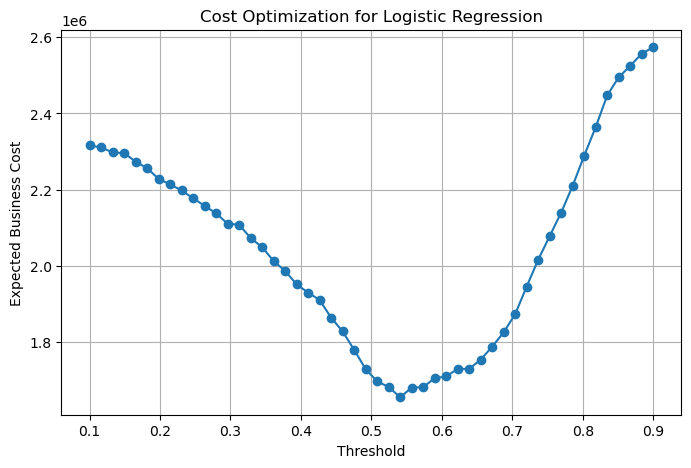

✅ Optimal Threshold: 0.54
✅ Minimum Cost: 1654000


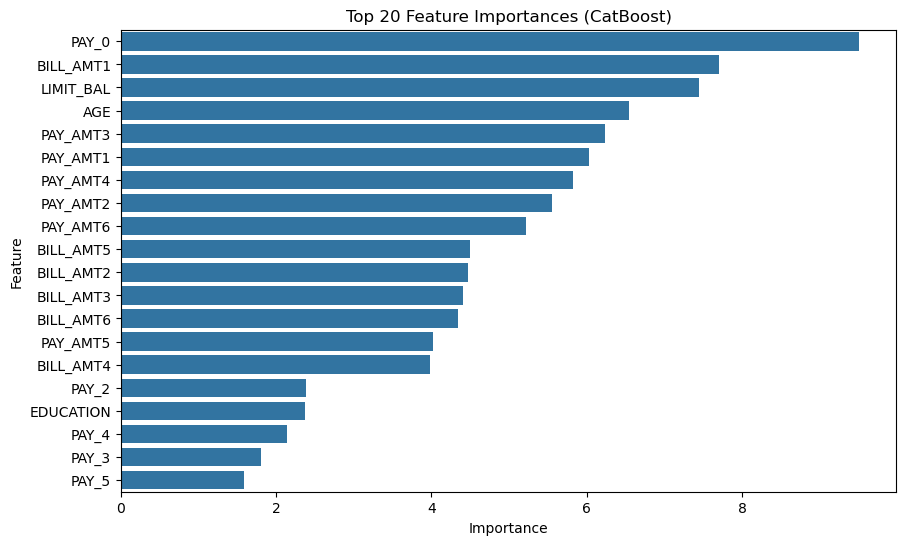

In [6]:
# Loan Default Risk with Business Cost Optimization (UCI Credit Card Dataset)
# =======================
# 2. Load Dataset
# =======================
# Replace with your dataset path
df = pd.read_csv(r"C:\Users\FARHAT\Downloads\Loan Default Risk with Business Cost Optimization\UCI_Credit_Card.csv")

print("Dataset shape:", df.shape)
print(df.head())


# =======================
# 3. Data Preprocessing
# =======================
# Drop columns with too many missing values (not common here, but safe)
df = df.dropna(axis=1, thresh=0.5 * len(df))

# Fill missing values if any
df = df.fillna(df.median(numeric_only=True))

# Target variable for UCI dataset
target_col = "default.payment.next.month"
y = df[target_col]
X = df.drop(columns=[target_col, "ID"])  # drop ID (not useful for modeling)

# One-hot encode categorical variables (if needed)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


# =======================
# 4. Train Models
# =======================
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train, y_train)
probs_val_lr = log_reg.predict_proba(X_val)[:, 1]

# CatBoost (if available)
if CATBOOST_AVAILABLE:
    cat_model = CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.1,
        loss_function="Logloss",
        eval_metric="AUC",
        verbose=0
    )
    cat_model.fit(X_train, y_train)
    probs_val_cb = cat_model.predict_proba(X_val)[:, 1]


# =======================
# 5. Evaluation Metrics
# =======================
def evaluate_model(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Threshold: {threshold:.2f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("-" * 40)


print("🔹 Logistic Regression Performance")
evaluate_model(y_val, probs_val_lr)

if CATBOOST_AVAILABLE:
    print("🔹 CatBoost Performance")
    evaluate_model(y_val, probs_val_cb)


# =======================
# 6. Cost-Benefit Analysis
# =======================
# Business costs (customize these values as per business case)
COST_REJECT_GOOD = 500   # Cost of rejecting a good client (False Positive)
COST_ACCEPT_BAD = 2000   # Cost of accepting a bad client (False Negative)

def expected_cost(y_true, y_probs, threshold, cfp, cfn):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * cfp + fn * cfn

# Try thresholds between 0.1 and 0.9
thresholds = np.linspace(0.1, 0.9, 50)
costs = []

for t in thresholds:
    cost = expected_cost(y_val, probs_val_lr, t, COST_REJECT_GOOD, COST_ACCEPT_BAD)
    costs.append(cost)

# Plot cost vs threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Expected Business Cost")
plt.title("Cost Optimization for Logistic Regression")
plt.grid(True)
plt.show()

best_threshold = thresholds[np.argmin(costs)]
print(f"✅ Optimal Threshold: {best_threshold:.2f}")
print(f"✅ Minimum Cost: {min(costs)}")


# =======================
# 7. Feature Importance
# =======================
if CATBOOST_AVAILABLE:
    feature_importances = cat_model.get_feature_importance()
    feature_names = X.columns
    feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
    feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
    plt.title("Top 20 Feature Importances (CatBoost)")
    plt.show()
